# Impulse Response Function (IRF) estimation: standard optimization in the time domain

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
from scipy.optimize import minimize

import matplotlib.pyplot as plt

### core methods

In [2]:
def generate_das_data(temperature, irf, noise=None, symmetrical=False):
    """ generate das data from a temperature time series and an impulse response function """
    te_data = temperature.data
    assert np.isnan(te_data).sum()==0, "temperature contains bad values"
    das_data = np.convolve(te_data, irf, mode='full')
    if symmetrical:
        das_data = das_data[irf.time.size//2:][:len(te_data)]
    else:
        das_data = das_data[:len(te_data)]
    # add noise
    if noise is not None:
        das_data += np.random.randn(das_data.size)*noise
    # combine as xarray object
    das = xr.DataArray(das_data, dims="time", coords=temperature.coords, name="das")
    return das

def irf_inference(
    temperature, das, irf_length, 
    symmetrical=False,
    #lambda_l2=.1, lambda_smooth=.1,
    lambda_l2=0, lambda_smooth=0,
    demean=True,
    opt_kwargs={},
):
    """ perform an inference of the impulse response function in the time domain
    
    Assumptions:
        - temperature and das data are a common time line
        - temperature data may NOT contain NaNs
        - das data may contain NaNs (corresponding to gaps)

    Parameters
    ----------
    temperature, das: xr.DataArray's
        input time series
    irf_length: int
        length of the impulse response function to be estimated
    symmetrical: boolean
        enables a symmetrical time lags for the definition of the impulse response function
    lambda_l2: float
        parameter constraining the amplitude of impulse response function values
    lambda_smooth: float
        parameter constraining the smoothness of impulse response function
    demean: boolean
        automatically demean time series
    opt_kwargs: dict
        options for the optimization method
    """

    if demean:
        temperature += -temperature.mean("time")
        das = das - das.mean("time")
    
    x = temperature.data
    y = das.data

    # mask start/end points which are not valid because of the convolution
    y[:irf_length] = np.nan
    y[-irf_length:] = np.nan
    
    assert x.ndim==1 and y.ndim==1, "temperature and das data should be one dimensional"
    
    assert np.isnan(x).sum()==0, "temperature contains bad values"
    y = np.nan_to_num(das.values, nan=0.0)          # Output series (convolved)
    valid = ~np.isnan(y)        # Only use points where output is not NaN
    
    def cost_function_reg(h):
        """ cost function to be minimized """
        if symmetrical:
            y_pred = np.convolve(x, h, mode='full')[len(h)//2:][:len(x)]
            lag = np.arange(-irf_length, irf_length)
        else:
            y_pred = np.convolve(x, h, mode='full')[:len(x)]
            lag = np.arange(irf_length)
        mse = np.mean((y[valid] - y_pred[valid])**2)
        l2_penalty = lambda_l2 * np.mean(h**2 / np.exp(-np.abs(lag)/60))
        smooth_penalty = lambda_smooth * np.mean(np.diff(h)**2)
        return mse + l2_penalty + smooth_penalty

    # Initial guess (as before): dirac
    if symmetrical:
        h0 = np.zeros(irf_length*2)
        h0[irf_length] = 1
        t_kernel = np.arange(-irf_length, irf_length)
    else:
        h0 = np.zeros(irf_length)
        h0[0] = 1
        t_kernel = np.arange(irf_length)
    # with exp:
    #h0 = np.exp(-t_kernel / 5)
    #h0 /= h0.sum()
    
    # Optimize with regularization
    _kwargs = dict(method='L-BFGS-B')
    _kwargs.update(opt_kwargs)
    result_reg = minimize(cost_function_reg, h0, **_kwargs)
    irf_inferred = result_reg.x

    # gather in one dataset
    irf = xr.DataArray(irf_inferred, dims="time", coords={"time": t_kernel})
    irf["time"].attrs.update(units="minutes")

    # predict das from temperature and the inferred response function
    das_inferred = generate_das_data(temperature, irf, symmetrical=symmetrical)

    #return irf, result_reg
    return irf, das_inferred

def irf_inference_windowed(temperature, das, irf_length, window, overlap=.5, **kwargs):
    """ perform an inference over overlapping windows of time and stack results in a single dataset
    
    Assumptions are similar to inference over a single window:
        - temperature and das data are a common time line
        - temperature data may NOT contain NaNs
        - das data may contain NaNs (corresponding to gaps)

    Parameters
    ----------
    temperature, das: xr.DataArray's
        input time series
    irf_length: int
        length of the impulse response function to be estimated
    window: int
        size of the windows used for each inference
    overlap: float in [0,1] interval
        parameter controling the temporal overlap of windows
    """
    
    # build rolling object
    ds = xr.merge([temperature.rename("temperature"), das.rename("das")])
    dsr = ds.rolling(time=window, center=True).construct("time_window", stride=int(window*overlap))
        
    # drops windows that do not have a full number of data points
    nan_count = np.isnan(dsr["temperature"]).sum("time_window")
    dsr = dsr.where(nan_count==0, drop=True)
    dsr = dsr.chunk(dict(time=1))

    # create template for map_blocks
    _ds = dsr.isel(time=[0]).compute()
    if "symmetrical" in kwargs and kwargs["symmetrical"]:
        out = _inference_wrapper(_ds, irf_length=irf_length, symmetrical=True)
    else:
        #irf_length=irf.time.size
        out = _inference_wrapper(_ds, irf_length=irf_length)
    _, out = xr.broadcast(dsr["time"], out)
    out = out.chunk(dict(time=1))

    # map inference over windows
    irfs = dsr.map_blocks(_inference_wrapper, kwargs=dict(irf_length=irf_length, **kwargs), template=out).compute()

    return irfs

def _inference_wrapper(ds, irf_length=None, **kwargs):
    ds = ds.squeeze()
    time = ds.time.values
    if time.ndim==0:
        time = [time]
    ds = ds.drop_vars("time")
    ds = ds.rename(time_window="time")
    assert ds.temperature.ndim==1, ds
    irf, das_inferred = irf_inference(ds.temperature, ds.das, irf_length, **kwargs)
    irf = (irf
        .rename("irf", time="time_irf")
        .expand_dims(time=time)
    )
    return irf

---
## generate synthetic data

In [3]:

def generate_synthetic_temperature_time_series(n_minutes, rho, sigma):
    """ Generate AR(1) process (Gaussian autocorrelation) """
    time = pd.date_range("2024-01-01", periods=n_minutes, freq="min")
    data = np.zeros(n_minutes)
    noise = np.random.normal(0, sigma, n_minutes)
    for t in range(1, n_minutes):
        data[t] = rho * data[t-1] + noise[t]
    da = xr.DataArray(data, coords={"time": time}, dims=["time"], name="temperature")
    da["time"].attrs.update(units="minutes")
    return da

def generate_IRF(tau, mode="exp", symmetrical=False):
    """ Create the impulse response kernel """
    kernel_length = int(10 * tau)  # kernel length in minutes
    if symmetrical:
        t_kernel = np.arange(-kernel_length,kernel_length)
        i0=kernel_length
    else:
        t_kernel = np.arange(kernel_length)
        i0=0
    if mode=="exp":
        impulse_response = np.exp(-np.abs(t_kernel) / tau)
        impulse_response = impulse_response / np.sum(impulse_response)
    elif mode=="dirac":
        impulse_response = np.zeros_like(t_kernel)
        impulse_response[i0] = 1
    irf = xr.DataArray(impulse_response, dims="time", coords={"time": t_kernel})
    irf["time"].attrs.update(units="minutes")
    return irf
    
def introduce_gaps(da, gap_fraction):
    """ introduce random gaps in time series """
    n_gaps = int(gap_fraction * n_minutes)
    gap_indices = np.random.choice(n_minutes, n_gaps, replace=False)
    data = da.data.copy()
    data[gap_indices] = np.nan
    
    da_with_gaps = xr.DataArray(
        data,
        dims=["time"],
        coords=da.coords,
        name=da.name+"_with_gaps",
    )

    return da_with_gaps

### generate 1 month of temperature/das data

In [4]:

# Parameters
n_minutes = 30 * 24 * 60  # 30 days of data, 1-minute intervals
rho = 0.95           # AR(1) autocorrelation coefficient
sigma = 1.0          # Standard deviation of noise

temperature = generate_synthetic_temperature_time_series(n_minutes, rho, sigma)
#te_data = temperature.data

# generate an impulse response function
tau = 10  # decay timescale in minutes
#t_kernel, irf = generate_IRF(tau, mode="dirac")
irf = generate_IRF(tau, mode="exp")

# generate synthetic das data
das = generate_das_data(temperature, irf)

# introduce gaps
gap_fraction = 0.1   # Fraction of data to be set as gaps
das_with_gaps = introduce_gaps(das, gap_fraction)

# merge in one dataset
ds = xr.merge([temperature, das, das_with_gaps])

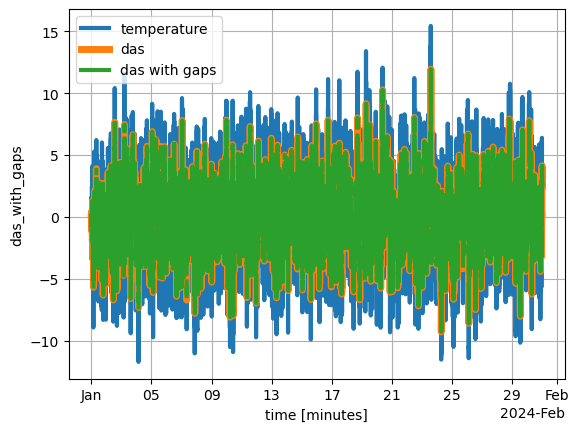

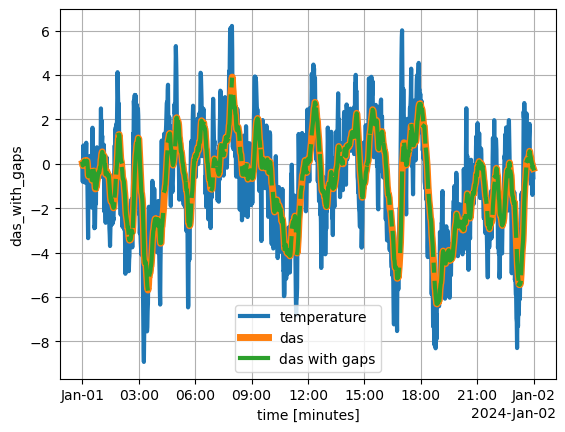

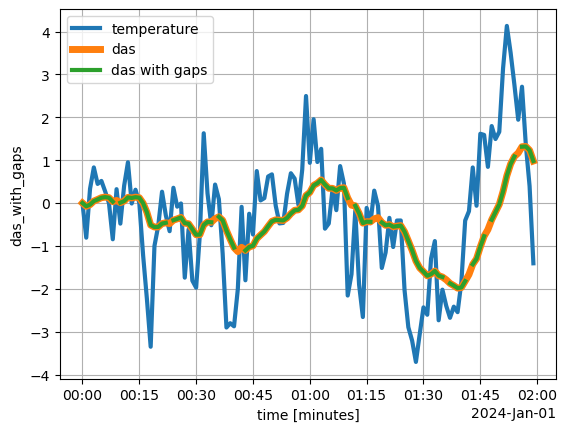

In [5]:
def plot(ds):
    fig, ax = plt.subplots(1,1)
    ds["temperature"].plot(label="temperature", lw=3)
    ds["das"].plot(label="das", lw=5)
    ds["das_with_gaps"].plot(label="das with gaps", lw=3)
    ax.legend()
    ax.grid()
    return ax

plot(ds)
plot(ds.isel(time=slice(0,24*60)))
plot(ds.isel(time=slice(0,2*60)));

## inference of the impulse response function

In [6]:
irf_inferred, ds["das_inferred"] = irf_inference(temperature, das, irf.time.size)

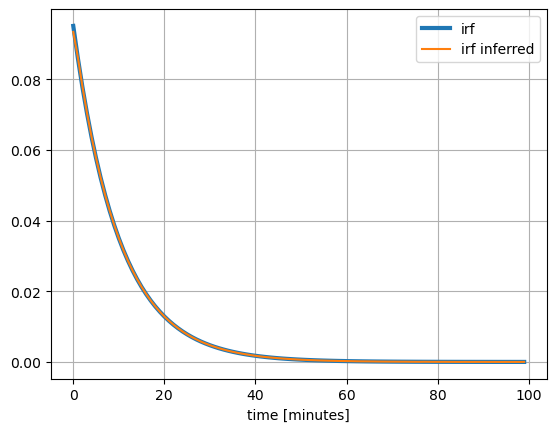

In [7]:
fig, ax = plt.subplots(1,1)
irf.plot(label="irf", lw=3)
irf_inferred.plot(label="irf inferred")
ax.legend()
ax.grid()

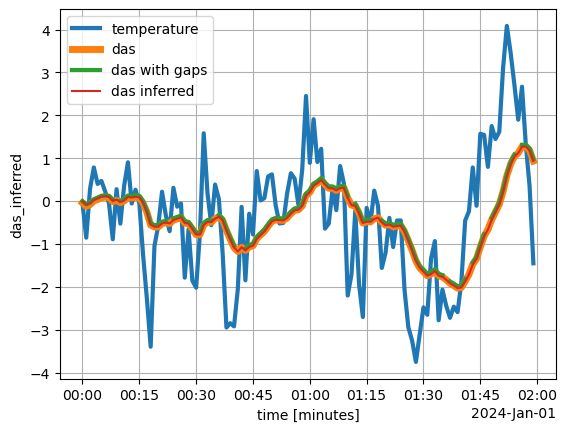

In [8]:
_ds = ds.isel(time=slice(0,2*60))
ax = plot(_ds)
_ds["das_inferred"].plot(ax=ax, label="das inferred")
ax.legend()

---
## windowed inference inference of the impulse response function

On 1-year timeseries.

We also add noise on das data

In [9]:
# Parameters
n_minutes = 30 * 24 * 60 * 12  # 30x12 days of data, 1-minute intervals
rho = 0.95           # AR(1) autocorrelation coefficient
sigma = 1.0          # Standard deviation of noise

temperature = generate_synthetic_temperature_time_series(n_minutes, rho, sigma)
#te_data = temperature.data

# generate an impulse response function
tau = 10  # decay timescale in minutes
#t_kernel, irf = generate_IRF(tau, mode="dirac")
irf = generate_IRF(tau, mode="exp")

# generate synthetic das data with noise
das = generate_das_data(temperature, irf, noise=1.)

# introduce gaps
gap_fraction = 0.1   # Fraction of data to be set as gaps
das_with_gaps = introduce_gaps(das, gap_fraction)

# merge in one dataset
ds = xr.merge([temperature, das, das_with_gaps])

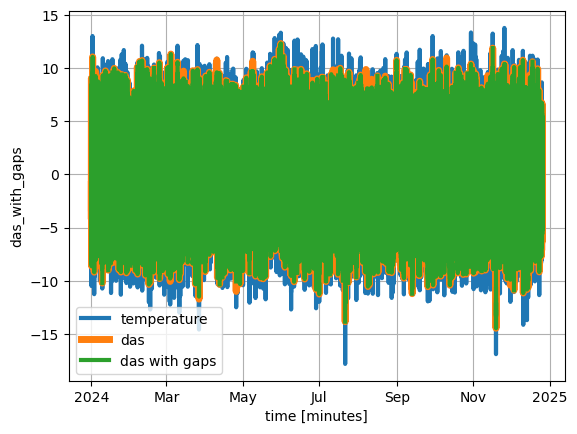

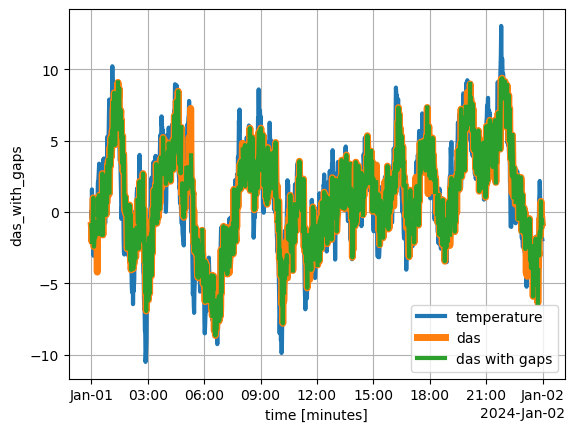

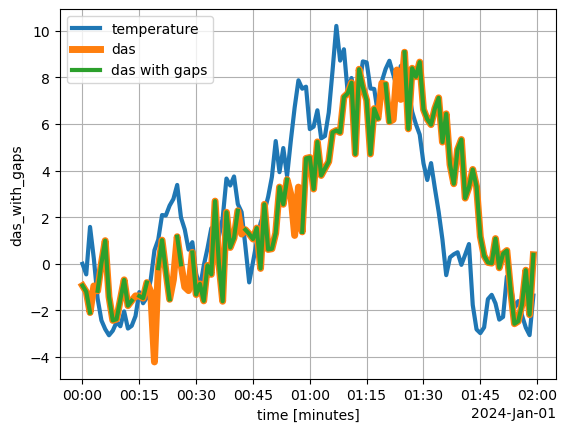

In [10]:
def plot(ds):
    fig, ax = plt.subplots(1,1)
    ds["temperature"].plot(label="temperature", lw=3)
    ds["das"].plot(label="das", lw=5)
    ds["das_with_gaps"].plot(label="das with gaps", lw=3)
    ax.legend()
    ax.grid()
    return ax

plot(ds)
plot(ds.isel(time=slice(0,24*60)))
plot(ds.isel(time=slice(0,2*60)));

### actually performs the inference over windows

In [11]:
window = 10*24*60 # 10 days
overlap = .5 # overlap
irf_length = irf.time.size # irf size

# add offset to temperature to test demeaning
temperature = ds.temperature+10
irfs = irf_inference_windowed(temperature, ds.das, irf_length, window)

### inspect irf over time to see an evolution over time

There is none obviously in the present case by design

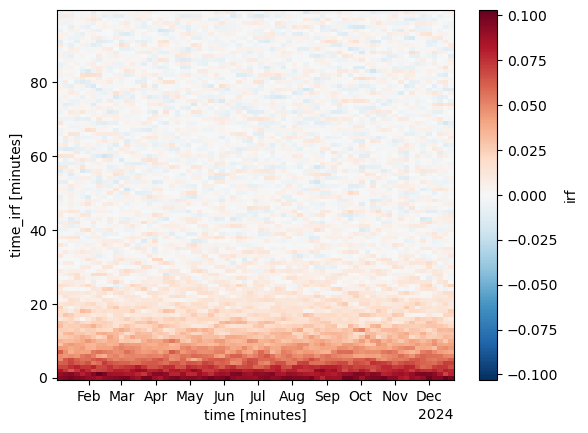

In [12]:
irfs.plot(x="time")

### assemble relevant statistics

In [13]:
# average irf
irf_mean = irfs.mean("time")

# quantiles for uncertainty quantification
irf_qt = irfs.quantile([.25,.75], dim="time")

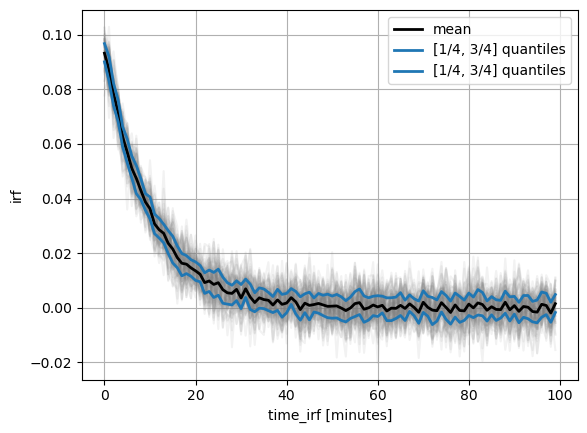

In [14]:
fig, ax = plt.subplots(1,1)
irfs.plot(hue="time", alpha=.1, color="0.5", add_legend=False);
irf_mean.plot(lw=2, color="k", label="mean")
irf_qt.plot(lw=2, color="C0", hue="quantile", label="[1/4, 3/4] quantiles")
ax.legend()
ax.grid()

---

## IRF with negative lags

In [15]:
# Parameters
n_minutes = 30 * 24 * 60 * 12  # 30x12 days of data, 1-minute intervals
rho = 0.95           # AR(1) autocorrelation coefficient
sigma = 1.0          # Standard deviation of noise

temperature = generate_synthetic_temperature_time_series(n_minutes, rho, sigma)
#te_data = temperature.data

# generate an impulse response function
tau = 10  # decay timescale in minutes
#t_kernel, irf = generate_IRF(tau, mode="dirac", symmetrical=True)
irf = generate_IRF(tau, mode="exp", symmetrical=True)

# generate synthetic das data with noise
das = generate_das_data(temperature, irf, noise=1., symmetrical=True)

# introduce gaps
gap_fraction = 0.1   # Fraction of data to be set as gaps
das_with_gaps = introduce_gaps(das, gap_fraction)

# merge in one dataset
ds = xr.merge([temperature, das, das_with_gaps])

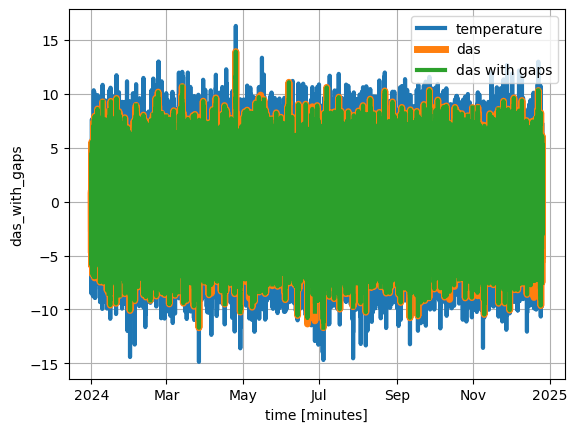

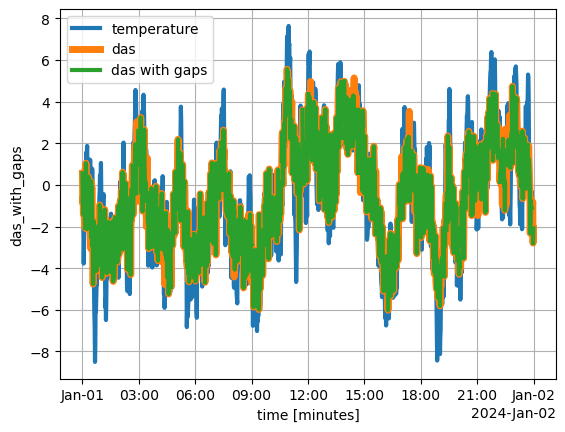

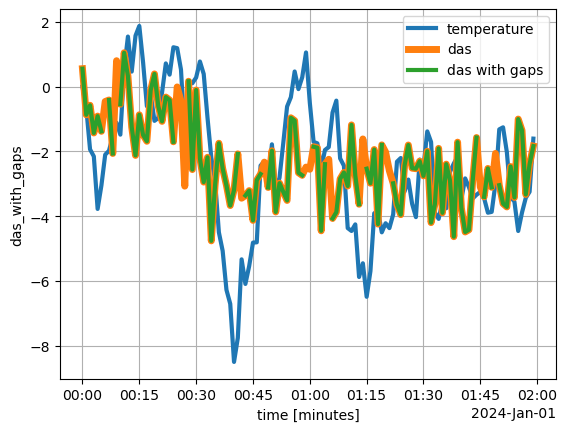

In [16]:
def plot(ds):
    fig, ax = plt.subplots(1,1)
    ds["temperature"].plot(label="temperature", lw=3)
    ds["das"].plot(label="das", lw=5)
    ds["das_with_gaps"].plot(label="das with gaps", lw=3)
    ax.legend()
    ax.grid()
    return ax

plot(ds)
plot(ds.isel(time=slice(0,24*60)))
plot(ds.isel(time=slice(0,2*60)));

**!! pay attention to the `irf_length//2` argument** below!!

In [ ]:
window = 10*24*60 # 10 days
overlap = .5 # overlap
irf_length = irf.time.size # irf size

# add offset to temperature to test demeaning
temperature = ds.temperature+10
irfs = irf_inference_windowed(temperature, ds.das, irf_length//2, window, symmetrical=True)

In [ ]:
# average irf
irf_mean = irfs.mean("time")

# quantiles for uncertainty quantification
irf_qt = irfs.quantile([.25,.75], dim="time")

In [ ]:
fig, ax = plt.subplots(1,1)
irfs.plot(hue="time", alpha=.1, color="0.5", add_legend=False);
irf_mean.plot(lw=2, color="k", label="mean")
irf_qt.plot(lw=2, color="C0", hue="quantile", label="[1/4, 3/4] quantiles")
ax.legend()
ax.grid()

---

## try with sample data

In [4]:
sample_dir = "/Users/aponte/Current_Projects/das/data/wemswot/das_temperature_debug"

das = xr.open_dataset(os.path.join(sample_dir,"S1_das_nstrain_d3424-3522.nc"))["nano_strain"]
te = xr.open_dataset(os.path.join(sample_dir,"S1_ctd_temperature.nc"))["temperature"]

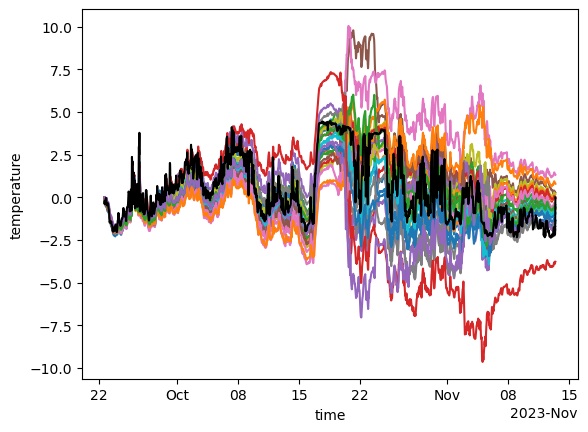

In [5]:
fig, ax = plt.subplots(1,1)
(das/10_000).plot.line(ax=ax, hue="distance", add_legend=False);
te.plot(ax=ax, color="k")

In [6]:
# subsample at 10 min
das10 = das.resample(time="10min").median()
te10 = te.resample(time="10min").median()

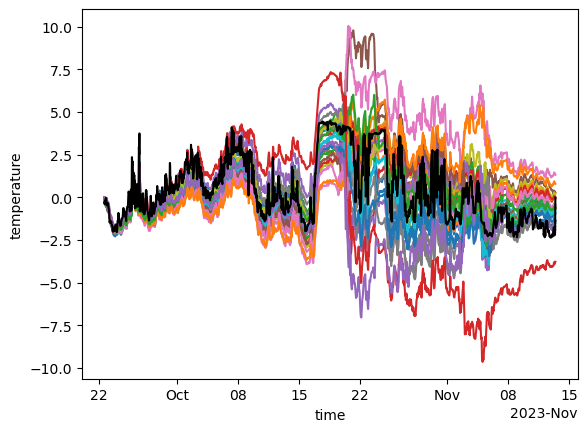

In [7]:
fig, ax = plt.subplots(1,1)
(das10/10_000).plot.line(ax=ax, hue="distance", add_legend=False);
te10.plot(ax=ax, color="k")

In [8]:
%%time

#irf_size = 1*24*60
irf_size = 12*60

d = 12 # channel

# 1 min 20 avec 1 pt par min
#_das = das.isel(distance=d)
_das = das10.isel(distance=d)
_te = te10

irf, das_inferred = irf_inference(_te, _das, irf_size, lambda_l2=0, lambda_smooth=0)
#irf, _ = irf_inference(_te, _das, irf_size)

CPU times: user 10.8 s, sys: 25.6 ms, total: 10.8 s
Wall time: 10.8 s


In [9]:
# activates norm constraint

das_std = float(_das.std("time"))
te_std = float(te.std("time"))
print(f"das std = {das_std:.2e} ns, te std = {te_std:.2e} degC")
print(f"das std / te std = {das_std/te_std:.2e} ns/degC")
std_ratio = das_std / te_std
irf_amplitude_guess = std_ratio/irf_size

I = []
D = []
#S = [1e4, 1e5, 1e6]
S = [1e1, 1e2, 1e3]
for s in S:
    l2 = s * te_std**2 / irf_amplitude_guess**2
    irf_l2, _das_inferred = irf_inference(_te, _das, irf_size, lambda_l2=l2, lambda_smooth=0)
    I.append(irf_l2)
    D.append(_das_inferred)
irf_l2 = xr.concat(I, dim=pd.Index(S, name="scale"))
das_l2 = xr.concat(D, dim=pd.Index(S, name="scale"))

das std = 1.41e+04 ns, te std = 1.87e+00 degC
das std / te std = 7.53e+03 ns/degC


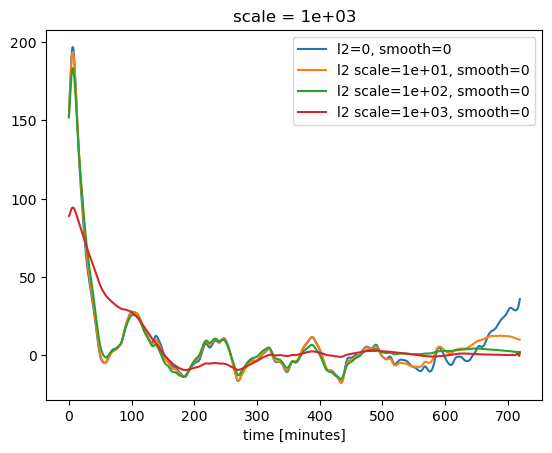

In [10]:
fig, ax = plt.subplots(1,1)
irf.plot(ax=ax, label="l2=0, smooth=0")
for s in irf_l2.scale:
    irf_l2.sel(scale=s).plot(ax=ax, label=f"l2 scale={float(s):.0e}, smooth=0")
ax.legend()

This shows success in constraining the amplitude of the IRF at larger lags.

Large weigths (10^3 scale) strongly distort the IRF.

In [11]:
def plot_tseries(i, _te, _das, das_inferred, das_l2):

    _scale = 1/10_000
    
    fig, axes = plt.subplots(2,1, figsize=(15,6), sharex=True)
    
    ax = axes[0]
    _te.isel(time=i).plot(ax=ax, color="k", lw=2, label="temperature")
    (_das.isel(time=i)*_scale).plot(ax=ax, color="0.5", lw=2, label="das original")
    (das_inferred.isel(time=i)*_scale).plot(ax=ax, label="l2=0,smooth=0")
    for s in das_l2.scale:
        (das_l2.isel(time=i).sel(scale=s)*_scale).plot(ax=ax, label=f"l2 scale={float(s):.0e}, smooth=0")
    ax.legend()
    ax.grid()
    ax.set_ylabel("nanostrain/10 000")
    ax.set_xlabel("")
    
    ax = axes[1]
    #(_das.isel(time=i) - _das_inferred.isel(time=i)*_scale).plot(ax=ax, color="0.5", lw=2, label="das original")
    _e = _das.isel(time=i) - _das_inferred.isel(time=i)
    (_e*_scale).plot(ax=ax, label="l2=0,smooth=0")
    for s in das_l2.scale:
        _e = _das.isel(time=i) - das_l2.isel(time=i).sel(scale=s)
        (_e*_scale).plot(ax=ax, label=f"l2 scale={float(s):.0e}, smooth=0")
    ax.grid()
    ax.set_title("error")
    ax.set_ylabel("nanostrain/10 000")

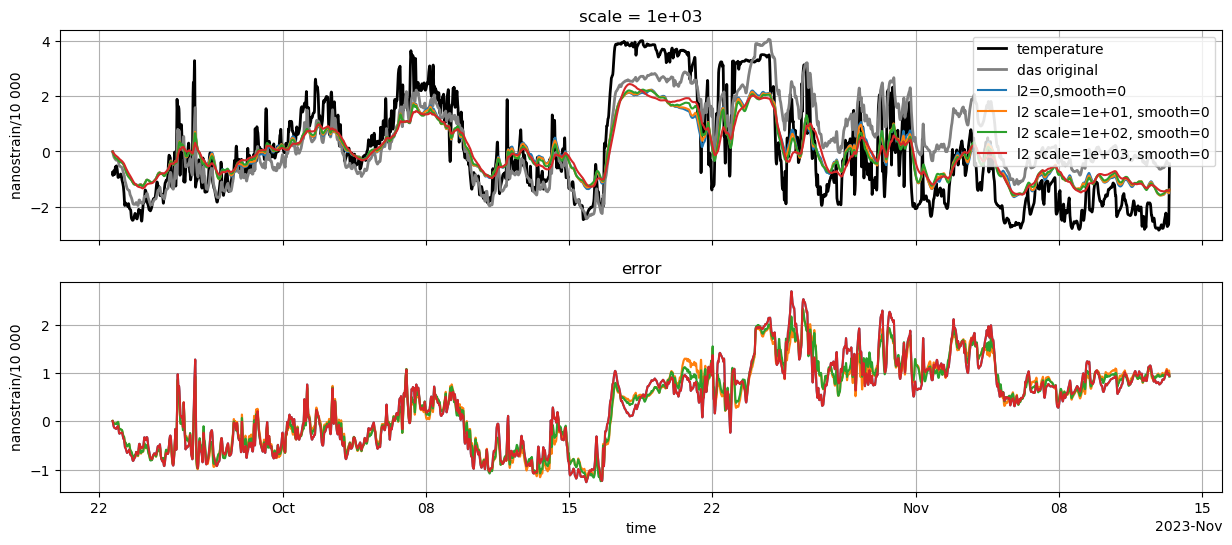

In [12]:
i = slice(0,None)
plot_tseries(i, _te, _das, das_inferred, das_l2)

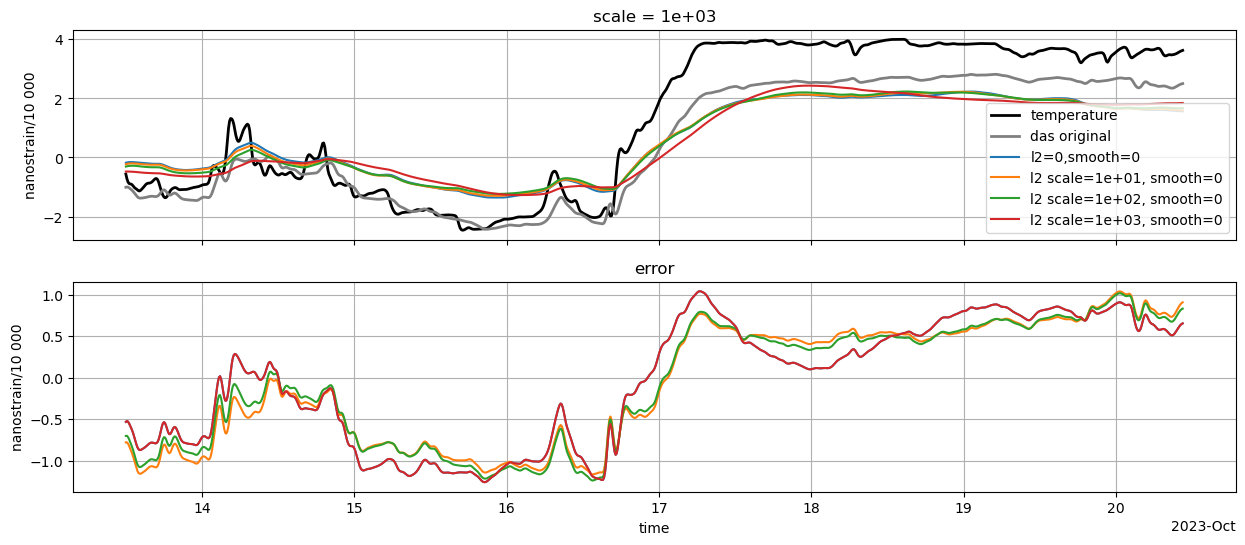

In [13]:
i = slice(3000,4000)
plot_tseries(i, _te, _das, das_inferred, das_l2)

In [14]:
# print errors
e = float((_das-das_inferred).std())
e_l2 = (_das - das_l2).std("time")
print(e, e_l2.values)

8065.024489644136 [8068.02277392 8112.16032614 8360.5577458 ]


The error standard deviation is likely controled by the larger error at low frequency.

There is little visual difference between intermediate and low weights (10 and 100 scales)

### same but with negative lags

In [15]:
irf, das_inferred = irf_inference(_te, _das, irf_size//2, lambda_l2=0, lambda_smooth=0, symmetrical=True)
#irf, _ = irf_inference(_te, _das, irf_size)

In [16]:
# activates norm constraint
I = []
D = []
#S = [1e4, 1e5, 1e6]
S = [1e1, 1e2, 1e3]
for s in S:
    l2 = s * te_std**2 / irf_amplitude_guess**2
    irf_l2, _das_inferred = irf_inference(_te, _das, irf_size//2, lambda_l2=l2, lambda_smooth=0, symmetrical=True)
    I.append(irf_l2)
    D.append(_das_inferred)
irf_l2 = xr.concat(I, dim=pd.Index(S, name="scale"))
das_l2 = xr.concat(D, dim=pd.Index(S, name="scale"))

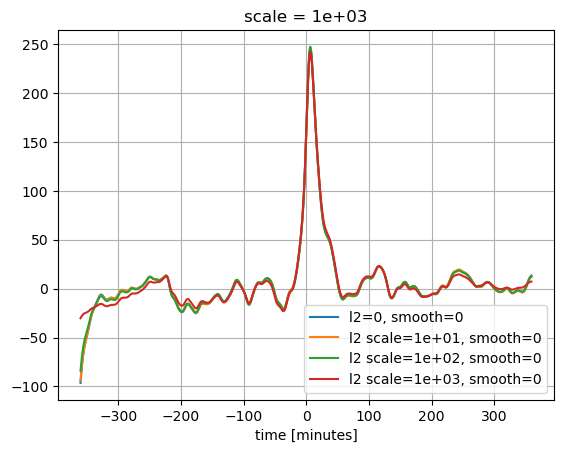

In [17]:
fig, ax = plt.subplots(1,1)
irf.plot(ax=ax, label="l2=0, smooth=0")
for s in irf_l2.scale:
    irf_l2.sel(scale=s).plot(ax=ax, label=f"l2 scale={float(s):.0e}, smooth=0")
ax.legend()
ax.grid()

Weights seem to have lesser importance at the peak with symmetrical windows

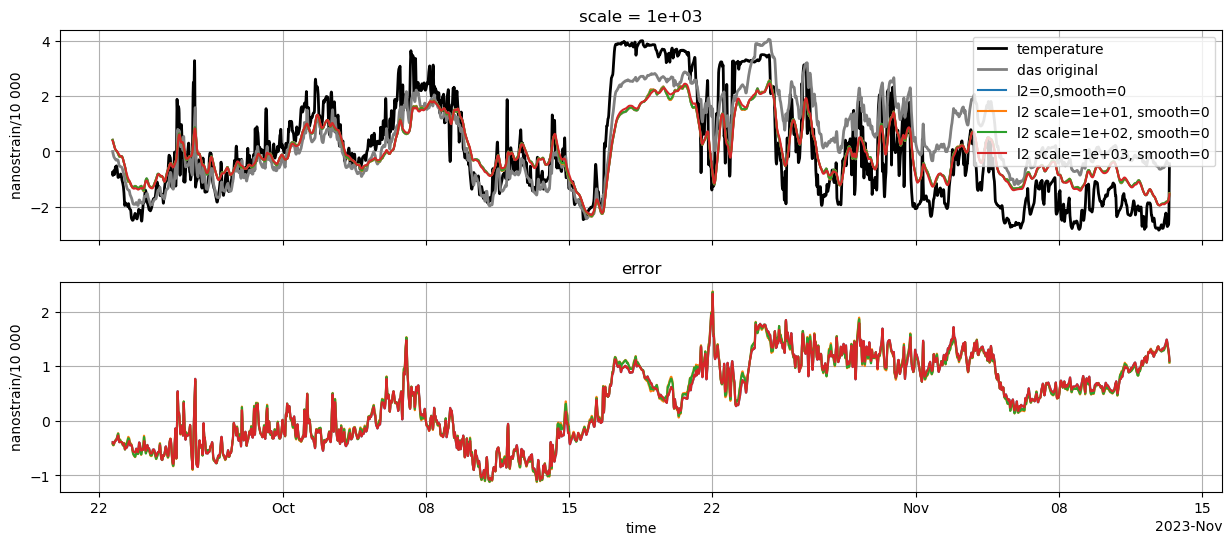

In [18]:
i = slice(0,None)
plot_tseries(i, _te, _das, das_inferred, das_l2)

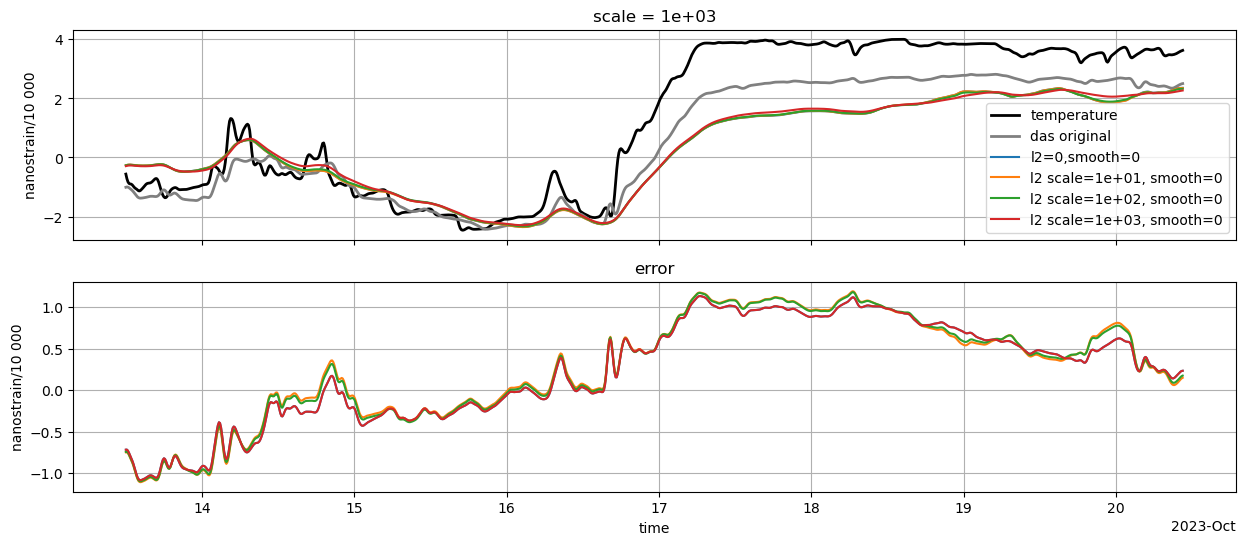

In [19]:
i = slice(3000,4000)
plot_tseries(i, _te, _das, das_inferred, das_l2)

In [20]:
# print errors
e = float((_das-das_inferred).std())
e_l2 = (_das - das_l2).std("time")
print(e, e_l2.values)

7299.762289171121 [7300.12917583 7304.21701769 7305.88919517]


Errors are smaller, we'll choose despite the uncertain physical meaning of this result

### broadcast calculation over all channels

In [21]:
# activates norm constraint
I = []
D = []

# l2 weight scaling
s = 1e3

_te = te10
te_std = float(te.std("time"))

D, I = [], []
for d in das10.distance:

    # 1 min 20 avec 1 pt par min
    #_das = das.isel(distance=d)
    _das = das10.sel(distance=d)
    
    # scalings
    das_std = float(_das.std("time"))
    #print(f"das std = {das_std:.2e} ns, te std = {te_std:.2e} degC")
    #print(f"das std / te std = {das_std/te_std:.2e} ns/degC")
    std_ratio = das_std / te_std
    irf_amplitude_guess = std_ratio/irf_size
    l2 = s * te_std**2 / irf_amplitude_guess**2
    
    irf_l2, _das_inferred = irf_inference(_te, _das, irf_size//2, lambda_l2=l2, lambda_smooth=0, symmetrical=True)
    
    I.append(irf_l2)
    D.append(_das_inferred)

irf_l2 = xr.concat(I, dim=das10.distance)
das_l2 = xr.concat(D, dim=das10.distance)

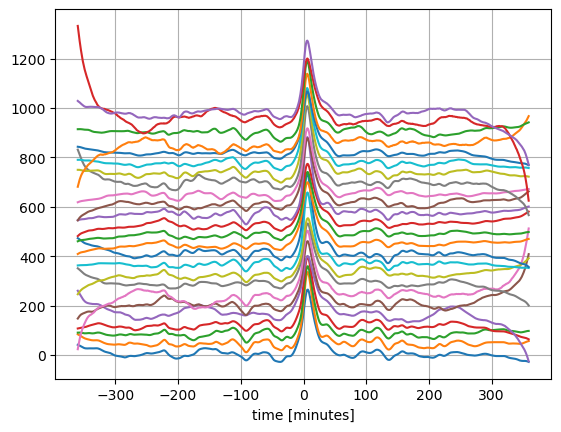

In [27]:
off = (irf_l2.distance - irf_l2.distance.min())*10

fig, ax = plt.subplots(1,1)
(irf_l2+off).plot(ax=ax, hue="distance", add_legend=False)
ax.grid()

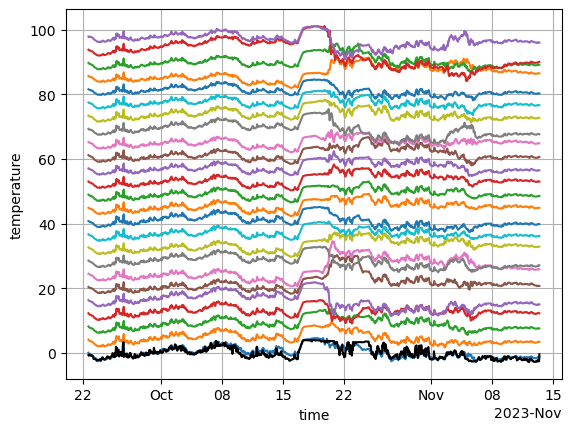

In [30]:
off = (irf_l2.distance - irf_l2.distance.min())*1

fig, ax = plt.subplots(1,1)
(off + das10/10_000).plot.line(ax=ax, hue="distance", add_legend=False);
te10.plot(ax=ax, color="k")
ax.grid()

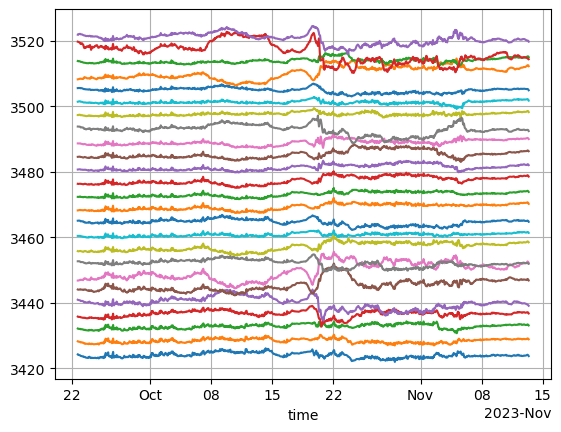

In [31]:
e = das10 - das_l2

off = (irf_l2.distance - irf_l2.distance.min())*1
fig, ax = plt.subplots(1,1)
(das10.distance + e/10_000).plot.line(ax=ax, hue="distance", add_legend=False);
ax.grid()

<BarContainer object of 25 artists>

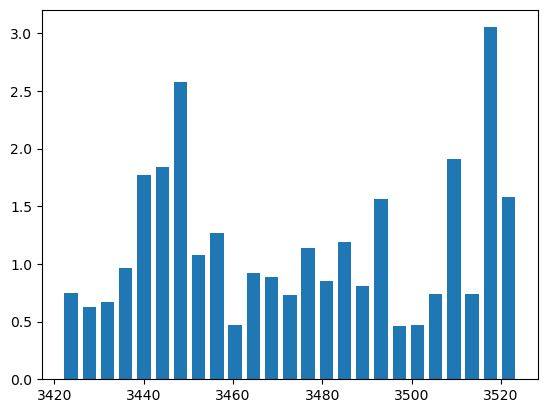

In [42]:
da = (e.std("time")/10_000)
fig, ax = plt.subplots(1,1)
ax.bar(da.distance, da.values, width=3)